In [ ]:
#Needed Imports:
import sys
if 'google.colab' in sys.modules:
    import matplotlib.pyplot as plt
    !pip install category_encoders
    !pip install pdpbox
    !pip install shap
    filepath = ''
else:
    filepath = 'data/'
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve
import shap

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Wrangle function. This is limited as the data is already cleaned by the competition:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path),
                      pd.read_csv(tv_path), on='building_id'
                      ).set_index('building_id')
    else:
        df = pd.read_csv(fm_path, index_col='building_id')
    return df

In [ ]:
#Data import:
df = wrangle('train_values.csv', 'train_labels.csv')
print(df.shape)
df.head()

(260601, 39)


,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3


In [ ]:
#Split the target and features:
target = 'damage_grade'
X = df.drop(columns=target)
y = df[target]
print(X.shape)
y.shape

(260601, 38)


(260601,)

In [ ]:
#Train/test split:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Baseline accuracy for classification problem is frequency of most common class:
print('Baseline accuracy:', y_train.value_counts(normalize=True).max())
#since there are three classes, the problem is unbalanced, 
#but I believe it's close enough to balanced to use our classification predictors

Baseline accuracy: 0.5697045280122793


In [ ]:
#Start with XGB classifier:
model_xgb = make_pipeline(
            OrdinalEncoder(),
            XGBClassifier(random_state=42, n_jobs=-1)
)
model_xgb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'legal_ownership_status'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_c

In [ ]:
#Preliminary scores:
print('XGB initial train score: ', model_xgb.score(X_train, y_train))
print('XGB initial validation score: ', model_xgb.score(X_val, y_val))

XGB initial train score:  0.6756523407521106
XGB initial validation score:  0.6746033268740047


In [ ]:
#These scores are decent, already better than baseline, let's use permutation importance to see if we can improve the model:
perm_imp = permutation_importance(model_xgb, X_val, y_val, random_state=42)
data = {'imp_mean':perm_imp['importances_mean'],
        'imp_std':perm_imp['importances_std']}
df_perm = pd.DataFrame(data, index=X_val.columns).sort_values('imp_mean')
df_perm

,imp_mean,imp_std
height_percentage,-0.000077,0.000120
has_secondary_use_hotel,-0.000019,0.000000
has_superstructure_rc_non_engineered,0.000000,0.000000
has_secondary_use_use_police,0.000000,0.000000
legal_ownership_status,0.000000,0.000000
has_secondary_use_institution,0.000000,0.000000
has_secondary_use_other,0.000000,0.000000
has_secondary_use_industry,0.000000,0.000000
has_secondary_use_health_post,0.000000,0.000000
has_secondary_use_gov_office,0.000000,0.000000


In [ ]:
#Let's remove the columns that have 0 or less importance mean.
cols_to_remove = df_perm[df_perm['imp_mean'] <= 0].index
model_xgb_ct = make_pipeline(
            OrdinalEncoder(),
            XGBClassifier(random_state=42, n_jobs=-1)
)
model_xgb_ct.fit(X_train.drop(columns=cols_to_remove), y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': n      1
o      2
t      3
NaN   -2
dtyp...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
      

In [ ]:
#Let's see if we get a better score without these columns:
print('XGB columns removed train score: ', model_xgb_ct.score(X_train.drop(columns=cols_to_remove), y_train))
print('XGB columns removed validation score: ', model_xgb_ct.score(X_val.drop(columns=cols_to_remove), y_val))

XGB columns removed train score:  0.6749856101304682
XGB columns removed validation score:  0.6742387905067055


In [ ]:
#There was a slight improvement in our validation score, so let's hyperparameter tune and see if we can get an even better score
clf = make_pipeline(
            OrdinalEncoder(),
            XGBClassifier(random_state=42, n_jobs=-1)
)
params_grid = {
    'xgbclassifier__learning_rate':np.arange(0.1, 1.0, 0.1),
    'xgbclassifier__n_estimators':range(50, 150, 10)
}

model = RandomizedSearchCV(
    clf, 
    param_distributions=params_grid,
    n_jobs=-1,
    n_iter=30,
    cv=5,
    verbose=1
    )
model.fit(X_train.drop(columns=cols_to_remove), y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 23.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 70.1min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('xgbclassifier',
                                              XGBClassifier(base_score=0.5,
                                                            booster='gbtree',
                                                            colsample_bylev

In [ ]:
#Let's get our best score:
model_be = model.best_estimator_
print('XGB hyperparameter tuned train score: ', model_be.score(X_train.drop(columns=cols_to_remove), y_train))
print('XGB hyperparameter tuned validation score: ', model_be.score(X_val.drop(columns=cols_to_remove), y_val))
model.best_params_

XGB hyperparameter tuned train score:  0.7304009976976209
XGB hyperparameter tuned validation score:  0.7236238752134456


{'xgbclassifier__learning_rate': 0.9, 'xgbclassifier__n_estimators': 120}

In [ ]:
#This is a significant improvement, but I think there's more to be gained from a different model.
#For now, let's use shap.waterfall_plot, but first we have to encode the data:
cols_to_encode = X.select_dtypes(include='object').columns
X_c = X.copy()
le = LabelEncoder()
for col in cols_to_encode:
    X_c[col] = le.fit_transform(X_c[col])

X_c_train = X_c.loc[X_train.index]
X_c_val = X_c.loc[X_val.index]

In [ ]:
#Next we need to re-fit the model without the pipeline, using the same hyperparameters:
model_np = XGBClassifier(n_estimators=140, learning_rate=0.5, random_state=42, n_jobs=-1)
model_np.fit(X_c_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=140, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
#Last, we need shap.Explainer:
explainer = shap.Explainer(model_np)
shap_values = explainer(X_c_val)

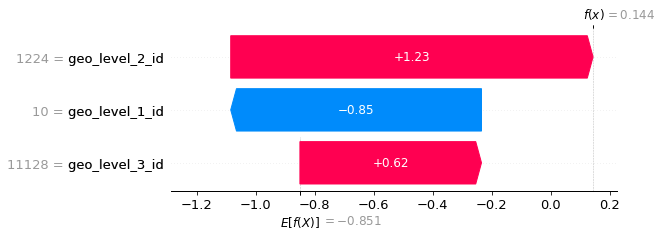

In [ ]:
#Finally, call shap.waterfall_plot
row = 0
shap.waterfall_plot(shap.Explanation(values=shap_values[0][row].base_values, 
                                     base_values=explainer.expected_value[0],
                                     data=X_c_val.iloc[row],  
                                     feature_names=X_c_val.columns.tolist()))

In [ ]:
#Let's try a random forest classifier instead:
model_rf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

model_rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'legal_ownership_status'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
          

In [ ]:
#Scores:
print('RF Training score before tuning: ', model_rf.score(X_train, y_train))
print('RF Validation score before tuning: ', model_rf.score(X_val, y_val))

RF Training score before tuning:  0.9867709132770529
RF Validation score before tuning:  0.7200168837896433


In [ ]:
#As expected, there's a lot of overfitting, let's try to get the permutation importance:
perm_imp = permutation_importance(model_rf, X_val, y_val, random_state=42)
data = {'imp_mean':perm_imp['importances_mean'],
        'imp_std':perm_imp['importances_std']}
df_perm = pd.DataFrame(data, index=X_val.columns).sort_values('imp_mean')
df_perm

,imp_mean,imp_std
has_secondary_use_rental,-0.000096,0.000050
has_secondary_use_institution,-0.000023,0.000008
has_secondary_use_industry,-0.000023,0.000014
has_secondary_use_health_post,0.000000,0.000000
has_secondary_use_use_police,0.000000,0.000000
has_secondary_use_school,0.000004,0.000008
has_secondary_use_gov_office,0.000019,0.000000
has_secondary_use_hotel,0.000042,0.000133
has_secondary_use_other,0.000138,0.000037
has_superstructure_rc_non_engineered,0.000295,0.000408


In [ ]:
#Remove the parameters with low importance:
cols_to_remove = df_perm[df_perm['imp_mean'] <= 0].index
model_rfdc = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)
model_rfdc.fit(X_train.drop(columns=cols_to_remove), y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'legal_ownership_status'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
          

In [ ]:
#Let's see the scores:
print('RF dropped low importance train score: ', model_rfdc.score(X_train.drop(columns=cols_to_remove), y_train))
print('RF dropped low importance validation score: ', model_rfdc.score(X_val.drop(columns=cols_to_remove), y_val))

RF dropped low importance train score:  0.9867757099002302
RF dropped low importance validation score:  0.7179639684580111


In [ ]:
#This model does worse on validation after the columns are removed so let's keep them in.
#Next let's look at hyperparameter tuning:
params_grid = {
    'randomforestclassifier__max_depth':range(15, 35, 2),
    'randomforestclassifier__n_estimators':range(50, 150, 25)
}

model = RandomizedSearchCV(
    model_rf, 
    param_distributions=params_grid,
    n_jobs=-1,
    n_iter=30,
    cv=5,
    verbose=1
    )
model.fit(X, y)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 73.8min finished
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=['land_surface_condition',
                                                                   'foundation_type',
                                                                   'roof_type',
                                                                   'ground_floor_type',
                                                                   'other_floor_type',
                                                                   'position',
                                                                   'plan_configuration',
                                                                   'legal_ownership_status'],
                                                             drop_invariant=False,
                                                             han

In [ ]:
#Let's look at our accuracy and parameters:
model_be = model.best_estimator_
print('RF hyperparameter tuned test score: ', model_be.score(X_train, y_train))
print('RF hyperparameter tuned score: ', model_be.score(X_val, y_val))
print(model.best_params_)

RF hyperparameter tuned test score:  0.9275470069071374
RF hyperparameter tuned score:  0.9288962222520672
{'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_depth': 29}


In [ ]:
#This is a much better result. Let's look at the classification report:
model_cr = classification_report(y_val, model_be.predict(X_val))
print(model_cr)

              precision    recall  f1-score   support

           1       0.99      0.86      0.92      5170
           2       0.91      0.97      0.94     29487
           3       0.95      0.87      0.91     17464

    accuracy                           0.93     52121
   macro avg       0.95      0.90      0.92     52121
weighted avg       0.93      0.93      0.93     52121



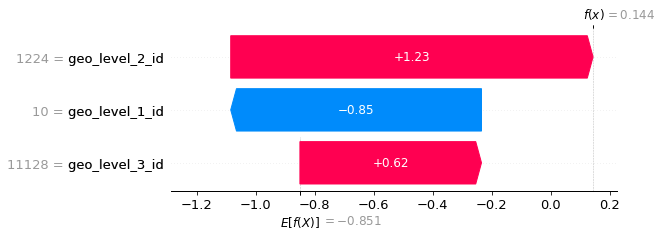

In [ ]:
#Precision and recall look really promising for all classes of our target.
#Let's also look at a shap waterfall:
model_bec = RandomForestClassifier(n_estimators=100, max_depth=29, n_jobs=-1, random_state=42)
model_bec.fit(X_c_train, y_train)
explainer = shap.Explainer(model_np)
shap_values = explainer(X_c_val)
row = 0
shap.waterfall_plot(shap.Explanation(values=shap_values[0][row].base_values, 
                                     base_values=explainer.expected_value[0],
                                     data=X_c_val.iloc[row],  
                                     feature_names=X_c_val.columns.tolist()))